**Modeling growth and propagation of bacterial colonies on flat surfaces.**

This protocol replicates the main text protocol that simulates demographic noise which causes spatial segregation of expanding, equally-fit colonies. 

In [1]:
import cobra
import cobra.test # for the ijo1366 model
import sys
import copy
import numpy as np
sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/COMETS-Python-Toolbox")
import comets as c

We will use the E. coli core model.

In [13]:
ecoli = cobra.test.create_test_model("textbook")

We will now convert this into a COMETS model, and set two parameter options: the demographic noise parameter, which is called "neutral drift," and convection-based motion parameters. 

In [14]:
grid_size = 100
ecoli_comets = c.model(ecoli)
ecoli_comets.initial_pop = [[x, 0, 1.] for x in range(grid_size)]
ecoli_comets.reactions.loc[ecoli_comets.reactions.EXCH, "LB"] = -1000
ecoli_comets.add_nonlinear_diffusion_parameters(convNonlinDiffZero = 0.,
                                    convNonlinDiffN = 6.e-6,
                                    convNonlinDiffExponent = 1.0,
                                    convNonlinDiffHillN = 2.,
                                    convNonlinDiffHillK = 0.001)
#toy_comets.add_neutral_drift_parameter(0.1)
ecoli_comets.add_noise_variance_parameter(0.01)

Note: for non-linear diffusion parameters to function,
params.all_params['biomassMotionStyle'] = 'ConvNonlin' Diffusion 2D'
must also be set


Let's make an exact copy of the ecoli comets model.

In [15]:
ecoli_comets2 = copy.copy(ecoli_comets)
ecoli_comets2.id = "e_coli_core2"

This simulation will be of a single, centered colony on a 100x100 grid. carbon will be spread homogenously, and be fixed at initial concentration along one end.

In [17]:
ly = c.layout([ecoli_comets, ecoli_comets2])
ly.grid = [grid_size, grid_size]
ly.set_specific_metabolite("glc__D_e", 2.2e-3)
ly.set_specific_metabolite("h2o_e", 1000)
ly.set_specific_metabolite("nh4_e", 1000)
ly.set_specific_metabolite("o2_e", 1000)
ly.set_specific_metabolite("pi_e", 1000)
ly.set_specific_metabolite("h_e", 1000)

for x in range(grid_size):
    ly.set_specific_static_at_location("glc__D_e", (x, grid_size-1), 2.2e-3)
    

The main parameter we need to set is biomassmotionstyle, which must be set to "ConvNonlin Diffusion 2D".  Then, to capture the spatial information, we'll also log biomass (instead of just total biomass). Finally, we'll also adjust a handful of other parameters. These are stored in the dictionary all_params.

In [8]:
p = c.params()

cycles = 20000

p.all_params["biomassMotionStyle"] = "ConvNonlin Diffusion 2D"
p.all_params["writeBiomassLog"] = True
p.all_params["BiomassLogRate"] = 1000
p.all_params["maxCycles"] = cycles
p.all_params["timeStep"] = 0.01
p.all_params["spaceWidth"] = 0.01
p.all_params["defaultDiffConst"] = 6.e-6
p.all_params["maxSpaceBiomass"] = 1000000
p.all_params["minSpaceBiomass"] = 1.0e-9
p.all_params["allowCellOverlap"] = True
p.all_params["growthDiffRate"] = 0
p.all_params["defaultVmax"] = 18.5
p.all_params["defaultKm"] = 0.000015
p.all_params["defaultHill"] = 1
p.all_params["exchangeStyle"] = "Monod Style"

Now we make a simulation object and run it.  This can take awhile.

In [9]:
sim = c.comets(ly, p)
# this should all be removable once the installer is made with dependencies in a predictable location
sim.set_classpath("concurrent", "/opt/colt/lib/concurrent.jar")
sim.set_classpath("colt", "/opt/colt/lib/colt.jar")
sim.set_classpath("lang3", "/opt/commons-lang3-3.9/commons-lang3-3.9.jar")
sim.set_classpath("jmatio","/opt/jmatio/lib/jmatio.jar")
sim.set_classpath("math3","/opt/commons-math3-3.6.1/commons-math3-3.6.1.jar")
sim.set_classpath("bin","/home/jeremy/Dropbox/work_related/harcombe_lab/segre/jars/comets_2.9.2.jar")
sim.set_classpath("gurobi","/opt/gurobi900/linux64/lib/gurobi.jar")
sim.set_classpath("jdistlib", "/opt/jdistlib-0.4.5-bin.jar")
sim.run()

    specifically, we cannot find the following libraries at these locations:

library common name 	 expected path
___________________ 	 _____________
gurobi	/opt/gurobi900/linux64/gurobi.jar
junit	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio	/Dropbox/work_related/ha

Now let's plot the results. Note how we specify the axes, otherwise "cycle", "x", and "y" will be assumed to be state variables. 

What we see is that both species survive, because the LCTStex_KO cross-feeds galactose from the galE_KO, which uses the glucose piece of lactose. The metabolites, as is typical in a chemostat, are in very low concentrations once equilibrium is reached.

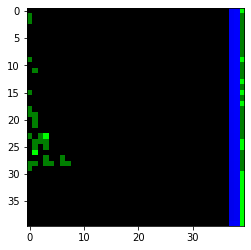

In [10]:
im = sim.get_biomass_image('e_coli_core', 10000).astype(int)
im = im / np.max(im)
im2 = sim.get_biomass_image('core2',10000).astype(int)
im2 = im2 / np.max(im2)
final = np.zeros((grid_size,grid_size,3))
final[:,:,1] = im
final[:,:,2] = im2
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))

plt.imshow(final)